In [1]:
# using Pkg; Pkg.update("TuLiPa"); Pkg.status() # uncomment to update TuLiPa to latest version
using DataFrames, Plots, Statistics, JSON, CSV, TuLiPa, Dates, HiGHS, JuMP
#plotlyjs() # uncomment for interactive plots

# Demo 6 - Two-stage stochastic hydro with Benders decomposition

This demo solves the same problem as demo 5, but this time we use Benders decomposition.

The guide below describes the method used in this demo. We use Benders decomposition for a two-stage minimization problem.
- https://jump.dev/JuMP.jl/stable/tutorials/algorithms/benders_decomposition/

The problem is split into a master problem (V1, first stage problem) and subproblems (V2, second stage scenarios).
- The master problem has a future value variable (θ) in the objective function, which represents the weighted objective value of the subproblems (V2(x)). The future value variable in the master problem is restricted by Benders cuts generated from the subproblems.
    - Benders cut: $\theta$ - $\bar{\pi}$ * x >= V2($\bar{x}$) - $\bar{\pi}$ * $\bar{x}$ where
        - θ is the future value variable
        - $\bar{\pi}$ is the water value of the end reservoir (solution from subproblems)
        - x is the end reservoir variable
        - V2($\bar{x}$) is the weighted objective value of the subproblems (solution from subproblems)
        - $\bar{x}$ is the end reservoir from the previous solved master problem (solution from previous master problem)
- The subproblems use the end reservoirs ($\bar{x}$) from the master problem as start reservoirs.
- This is an iterative process where the future value variable converges towards the weighted subproblem objective value
- The iteration is stopped when the relative difference between lb = $\theta$ and ub = V2($\bar{x}$) is under a tolerance factor.

Dataset:
- You could also choose from the 125 Norwegian watercourses in TuLiPa/demos/dataset_vassdrag. NVEs dataset for the hydropower system in 2022 is open, but we have not published datasets for 2025/2030/2040/2050 since it would reveal investment plans. The dataset exist in several formats:
    - Aggregated (for Res and RoR) production capacity, reservoir capacity, inflow and inflow profiles per price areas from https://www.nve.no/energi/analyser-og-statistikk/vaerdatasett-for-kraftsystemmodellene/
    - Detailed watercourse descriptions from https://www.nve.no/energi/energisystem/vannkraft/modell-av-det-norske-vannkraftsystemet/. The dataset exist in two DETD-formats (per EMPS area (also includes rest modules for small-scale hydro) or per watercourse), and simplified in an Excel-format. The dataset used in this demo is derived from the excel-format with some differences: 
        - Every water balance has its own module (i.e. a module with both regulated and unregulated inflow is split into two modules). 
        - It has pq-kurves and environmental restrictions
    - The inflow series for the detailed dataset can be found at https://www.nve.no/vann-og-vassdrag/hydrologiske-data/historiske-data/historiske-vannfoeringsdata-til-produksjonsplanlegging/. 
- We use one of the 11 [Hydrocen 2030 low emission price series](https://hydrocen.nina.no/Resultater/%C3%85pne-og-tilgjengelige-prisprognoser-for-str%C3%B8m) from different Norwegian EMPS areas:
    - Ostland, Sorost, Hallingdal, Telemark, Sorland, Vestsyd, Vestmidt, Norgemidt, Helgeland, Troms, Finnmark
    - [A map to locate the EMPS areas (NVE has 15 EMPS areas so a bit different)](https://www.nve.no/media/14912/norge-samkjoeringsmodellomraader-og-prisomraader-oktober_2021.pdf)
    - Possible mapping of EMPS areas to elspot areas: NO1 -> Ostland, NO2 -> Sorland, NO3 -> Norgemidt, NO4 -> Troms, NO5 -> Vestsyd

### Make modelobjects for the master and subproblems

In [2]:
function getdataelements()
    # Read dataelements from json-files
    sti_dynmodelldata = "dataset_vassdrag"
    price = JSON.parsefile("priceDMK.json")
    detdprice = getelements(price);
    tidsserie = JSON.parsefile(joinpath(sti_dynmodelldata, "tidsserier_detd.json"))
    detdseries = getelements(tidsserie, sti_dynmodelldata);
    dst = JSON.parsefile(joinpath(sti_dynmodelldata, "dataset_detd_AURLAND_H.json"))
    detdstructure = getelements(dst);

    elements = vcat(detdseries,detdprice,detdstructure)
    
    # Select which scenarios to include from the time-series
    scenarioyearstart = 1981
    scenarioyearstop = 1996 # price series only goes to 1995
    push!(elements, getelement(TIMEPERIOD_CONCEPT, "ScenarioTimePeriod", "ScenarioTimePeriod", 
            ("Start", getisoyearstart(scenarioyearstart)), ("Stop", getisoyearstart(scenarioyearstop))))
    
    # Add an exogenous price area that the plants and pumps can interact with. All units are in NO5.
    addexogenbalance!(elements, "PowerBalance_NO5", "Power", "AreaPrice")

    # Add dataelements for price in exogen area
    file = "Prices_HydroCen_LowEmission_2030_1958-2015.csv"
    df = CSV.read(file, DataFrame; header=3, decimal=',', types=Float64)
    df[:,"aar"] = cld.(1:first(size(df)), 2912) .+ 1957
    df[:,"tsnitt"] = rem.(0:(first(size(df))-1), 2912) .+ 1
    df.datetime .= getisoyearstart.(Int.(df.aar)) + Hour.((df.tsnitt.-1)*3) # TODO: Include week 53. Now ignored and flat prices.
    push!(elements, DataElement(TIMEINDEX_CONCEPT,"VectorTimeIndex","AreaPriceProfileIndex",
            Dict("Vector" => df.datetime)))
    push!(elements, DataElement(TIMEVALUES_CONCEPT,"VectorTimeValues","AreaPriceProfileValues",
            Dict("Vector" => df[:,"Vestsyd"].*1000))) # *1000 to go from €/MWh to €/GWh
    push!(elements, getelement(TIMEVECTOR_CONCEPT,"RotatingTimeVector","AreaProfile",
            (TIMEINDEX_CONCEPT,"AreaPriceProfileIndex"),(TIMEVALUES_CONCEPT,"AreaPriceProfileValues")))
    addparam!(elements, "MeanSeriesParam", "AreaPrice", 1.0, "AreaProfile")
    
    return elements
end

function makemodelobjects(elements, weeks::Int,offset::Union{Offset,Nothing})
    # Add horizons to the dataset
    hydro_horizon = SequentialHorizon(weeks, Hour(168); offset)
    power_horizon = SequentialHorizon(7*weeks, Hour(24); offset)
    push!(elements, getelement(COMMODITY_CONCEPT, "BaseCommodity", "Power", 
            (HORIZON_CONCEPT, power_horizon)))
    push!(elements, getelement(COMMODITY_CONCEPT, "BaseCommodity", "Hydro", 
            (HORIZON_CONCEPT, hydro_horizon)))
    
    # Generate modelobjects from dataelements and add boundary conditions to storages
    return getmodelobjects(elements)
end;

In [3]:
# Total problem length is 105 weeks = approx 2 years, and first stage problem is eight weeks
totalweeks = 105
firstweeks = 8

# Read dataelements that will be in both the first stage and second stage problems
elements = getdataelements()

# Make modelobjects for first stage problem
firstobjects = makemodelobjects(copy(elements), firstweeks, nothing)

# Make modelobjects for 10 second stage scenarios. Each scenario start eight weeks into a weather year.
numscen = 10

secondobjects = []
for i in 1:numscen
    scenarioyearstart = 1981+i-1 # Scenarios start in 1981, 1982, etc...
    offset = IsoYearOffset(scenarioyearstart, MsTimeDelta(Week(firstweeks)))
    push!(secondobjects, makemodelobjects(copy(elements), totalweeks-firstweeks, offset))
end

### Problem start time

In [4]:
# Problem start time
datayear = getisoyearstart(2025)
scenarioyear = getisoyearstart(1981)

# We use a PhaseinTwoTime to get smooth transitions between the first stage and second stage scenario
phaseinoffset = Millisecond(Week(firstweeks)) # phase in straight away from second stage scenarios
phaseindelta = Millisecond(Week(26)) # Phase in the second stage scenario over half a year
phaseinsteps = 25 # Phase in second stage scenario in 25 steps

t = PhaseinTwoTime(datayear, scenarioyear, scenarioyear, phaseinoffset, phaseindelta, phaseinsteps);

### Initialize masterproblem

In [5]:
# Get cutobjects
function getcutobjects(modelobjects)
    cutobjects = Vector{Any}()
    for (id,obj) in modelobjects
        if hasstatevariables(obj)
            if length(TuLiPa.getstatevariables(obj)) > 1
                error("Not supported")
            else
                push!(cutobjects,obj)
            end
        end
    end
    return cutobjects
end

# Initialize cuts
function initialize_cuts!(modelobjects, cutobjects, maxcuts, lb, numscen)
    # Make a cutid
    cutid = Id(BOUNDARYCONDITION_CONCEPT,"StorageCuts")
    
    # Probability of each subproblem / second stage scenario
    probabilities = [1/numscen for i in 1:numscen]
    
    # Make cut modelobject
    cuts = SimpleSingleCuts(cutid, cutobjects, probabilities, maxcuts, lb)
    modelobjects[cutid] = cuts
    return cuts
end

# Initialize list of the statevariables that connects the master and subproblem. For each model object with state 
# variables (here reservoirs), we store the state variables of the master problem, and the boundary reservoir level 
# (end storage in master and start storage in sub). (We do not need to store the he initial statevariables of the 
# subproblems seperately, since they have the same id and index as the initial statevariables of the master problem)
function getstatevariables(cutobjects::Vector{Any})
    states = Dict{StateVariableInfo, Float64}()
    
    for obj in cutobjects
        for statevariable in TuLiPa.getstatevariables(obj)
            states[statevariable] = 0.0
        end
    end
    return states
end

maxcuts = 13 # preallocate fixed number of cuts, no cut selection
lb = -1e10 # lower bound of the future value in the first iteration
cutobjects = getcutobjects(firstobjects)
cuts = initialize_cuts!(firstobjects, cutobjects, maxcuts, lb, numscen);
states = getstatevariables(cutobjects) # state variables in master and subs for boundary reservoirs

# Build problem and update parameters
master = HiGHS_Prob(firstobjects)
update!(master, t)

# Set start reservoir as a percentage of capacity
function setstartstorage!(prob, start, percentage)
    for obj in prob.objects
        if obj isa Storage

            dummydelta = MsTimeDelta(Millisecond(0))
            startreservoir = getparamvalue(getub(obj), start, dummydelta)*percentage/100
            
            ingoingstates = Dict{StateVariableInfo, Float64}()
            for statevariable in TuLiPa.getstatevariables(obj)
                ingoingstates[statevariable] = startreservoir
            end
            
            setingoingstates!(prob, ingoingstates)
        end
    end
end

function setendstorage!(prob, endtime, percentage)
    for obj in prob.objects
        if obj isa Storage

            dummydelta = MsTimeDelta(Millisecond(0))
            endreservoir = getparamvalue(getub(obj), endtime, dummydelta)*percentage/100
            
            outgoingstates = Dict{StateVariableInfo, Float64}()
            for statevariable in TuLiPa.getstatevariables(obj)
                outgoingstates[statevariable] = endreservoir
            end
            
            setoutgoingstates!(prob, outgoingstates)
        end
    end
end

percentage = 65
setstartstorage!(master, t, percentage)

### Solve masterproblem and query results

In [6]:
solve!(master)
getobjectivevalue(master)

-1.0071469149465286e10

In [7]:
lb = getvarvalue(master, getfuturecostvarid(cuts),1)

-1.0e10

### Initialize, solve and query subproblems

In [8]:
# Transfer master problem end reservoir to subproblems (start reservoir)
function transferboundarystorage!(master, sub, states)
    states = getoutgoingstates!(master, states)
    setingoingstates!(sub, states)
end

subs = [HiGHS_Prob(secondobject) for secondobject in secondobjects] # initialize subproblems
ub = 0 # upper bound is a sum of weighted subproblem objective values
        
for (i,sub) in enumerate(subs)
    
    update!(sub, t) # update parameters given problem start time of scenario
    
    transferboundarystorage!(master, sub, states) # set start reservoir
    setendstorage!(sub, t + MsTimeDelta(Week(totalweeks-firstweeks)), percentage) # set end reservoir
    
    solve!(sub)
    
    ub += getobjectivevalue(sub)
    getscencutparameters!(sub, cuts, states, i)
end

ub /= numscen # subproblems are weighted equally

-1.87589625802523e8

### Check convergence
The convergence criteria calculates a relative difference from the upper and lower bound of the future cost, and compares it to a relative tolerance.
- The lower bound is the future cost from the master problem.
- The upper bound is the weighted objective values from the subproblems.

In [9]:
reltol = 0.0001 # relative tolerance
display(abs((lb-ub)/ub)) # relative difference
display(abs((lb-ub)/ub) < reltol) # convergence?

52.307851951936165

false

### Update cuts

In [10]:
updatecutparameters!(master, cuts)
updatelastcut!(master, cuts)

### Iterate until convergence

In [11]:
@time while abs((lb-ub)/lb) > reltol
    solve!(master)
    lb = getvarvalue(master, getfuturecostvarid(cuts),1)
    masterlb = getobjectivevalue(master)
    cx = masterlb - lb
    
    masterub = 0
    ub = 0
    for (i,sub) in enumerate(subs)

        transferboundarystorage!(master, sub, states)

        solve!(sub)

        ub += getobjectivevalue(sub)
        getscencutparameters!(sub, cuts, states, i)
    end
    ub /= numscen
    masterub = min(masterub,ub+cx)
    updatecutparameters!(master, cuts)
    updatelastcut!(master, cuts)
    display(string("Cut: ", cuts.cutix))
    display("Master lb and ub:")
    display(masterlb)
    display(masterub)
    display("Future value lb and ub, and relative difference:")
    display(lb)
    display(ub)
    display((ub-lb)/lb)
#     plot_results()
end

"Cut: 2"

"Master lb and ub:"

-2.755294000769169e8

-2.663722941182e8

"Future value lb and ub, and relative difference:"

-2.695012725741443e8

-2.6034416661542743e8

-0.033977969273587

"Cut: 3"

"Master lb and ub:"

-2.703867528370582e8

-2.6888874206902283e8

"Future value lb and ub, and relative difference:"

-2.0984526700922072e8

-2.0834725624118537e8

-0.007138644532638083

"Cut: 4"

"Master lb and ub:"

-2.699121369696468e8

-2.691865949236551e8

"Future value lb and ub, and relative difference:"

-2.263193833634183e8

-2.255938413174266e8

-0.0032058325504831396

"Cut: 5"

"Master lb and ub:"

-2.6953500915098417e8

-2.692643160521698e8

"Future value lb and ub, and relative difference:"

-2.2373721996694052e8

-2.2346652686812615e8

-0.001209870663693622

"Cut: 6"

"Master lb and ub:"

-2.6939756837164986e8

-2.693285378341683e8

"Future value lb and ub, and relative difference:"

-2.2261063098123023e8

-2.2254160044374865e8

-0.0003100954216665269

"Cut: 7"

"Master lb and ub:"

-2.693447147817754e8

-2.693301359531695e8

"Future value lb and ub, and relative difference:"

-2.21204758980527e8

-2.2119018015192112e8

-6.590648715280882e-5

  0.971122 seconds (404.19 k allocations: 26.501 MiB, 55.48% compilation time)


### Plot some results

In [12]:
function plot_var(master, subs, id, datayear)
    obj = firstobjects[id]
    horizon = gethorizon(obj)

    x = [datayear + getstartduration(horizon, t) for t in 1:getnumperiods(horizon)]
    y = [getvarvalue(master, id, t) for t in 1:getnumperiods(horizon)]
    plot(x,y,label="First stage", title=getinstancename(id))
    
    for i in 1:numscen
        obj = secondobjects[i][id]
        horizon = gethorizon(obj)
        x1 = [datayear + Millisecond(Week(firstweeks)) + getstartduration(horizon, t) for t in 1:getnumperiods(horizon)]
        y1 = [getvarvalue(subs[i], id, t) for t in 1:getnumperiods(horizon)]
        plot!(x1,y1,label=string("Scenario ", i),legend=:outertopright)
    end

    display(plot!())
end

function plot_price(master, subs, id, t)
    obj = firstobjects[id]
    horizon = gethorizon(obj)
    price = getprice(obj)
    datayear = getdatatime(t)

    probtimes = [t + getstartduration(horizon, j) for j in 1:getnumperiods(horizon)]
    x = [datayear + getstartduration(horizon, j) for j in 1:getnumperiods(horizon)]
    y = [getparamvalue(price, probtimes[j], gettimedelta(horizon, j)) for j in 1:getnumperiods(horizon)]/1000
    plot(x,y,label="First stage",title=getinstancename(id),legend=:outertopright)
    
    for i in 1:numscen
        obj = secondobjects[i][id]
        horizon = gethorizon(obj)
        probtimes1 = [getoffsettime(t,getoffset(horizon)) + getstartduration(horizon, j) for j in 1:getnumperiods(horizon)]
        x1 = [datayear + Millisecond(Week(firstweeks)) + getstartduration(horizon, j) for j in 1:getnumperiods(horizon)]
        y1 = [getparamvalue(price, probtimes1[j], gettimedelta(horizon, j)) for j in 1:getnumperiods(horizon)]/1000
        plot!(x1,y1,label=string("Scenario ", i))
    end

    display(plot!())
end

function plot_results()
    concept = BALANCE_CONCEPT
    instance = "PowerBalance_NO5"
    id = Id(concept, instance)

    plot_price(master, subs, id, t)

    concept = STORAGE_CONCEPT
    instance = "Reservoir_29302"
    id = Id(concept, instance)

    plot_var(master, subs, id, datayear)

    concept = FLOW_CONCEPT
    instance = "Release_29302"
    id = Id(concept, instance)

    plot_var(master, subs, id, datayear)
end

plot_results (generic function with 1 method)

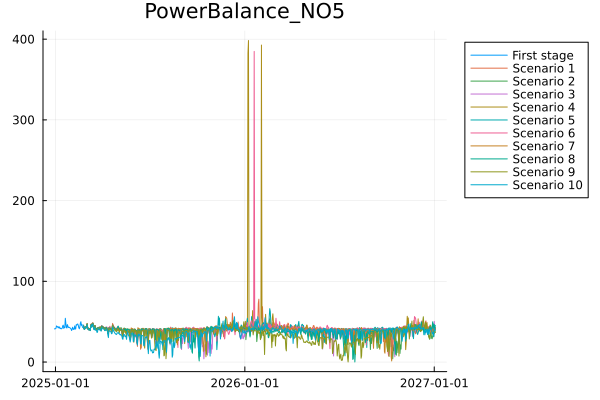

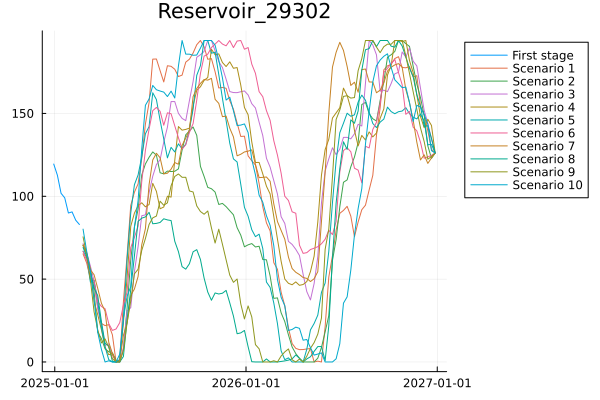

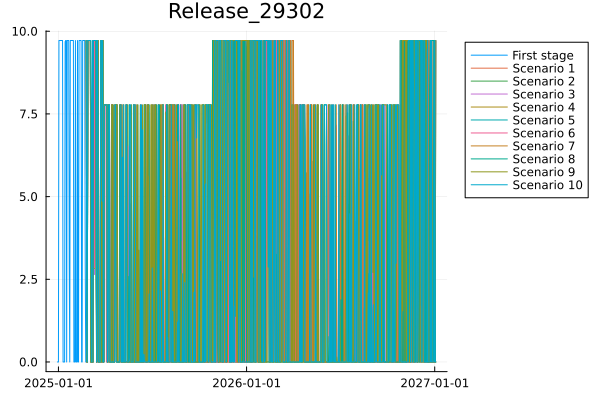

In [13]:
plot_results()